In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from keras import models, layers
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, label_ranking_average_precision_score
from tensorflow.keras.applications import resnet50

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(10)

In [ ]:
def CreateResNetModel(Xtrain, ytrain, layersToUnfreeze, opt):
    resModel = resnet50.ResNet50(include_top = False, weights = 'imagenet', input_shape = (288,432,3))

    if (layersToUnfreeze == 0 ):
      for layer in resModel.layers: #freeze all layers 
        layer.trainable = False 
    else:
      for layer in resModel.layers[:- layersToUnfreeze]: #we want to train the last several layers
        layer.trainable = False
    
    output = resModel.layers[-1].output 
    output = Flatten()(output)
    output = Dense(512, activation = 'relu')(output)
    output = Dropout(0.5)(output)
    output = Dense(24, activation = 'softmax')(output)
    
    model = models.Model(inputs = resModel.input, outputs = output)
    model.compile( loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
    
    history = model.fit(Xtrain, ytrain, epochs = 50)
    return model, history

In [ ]:
def ResnetEvaluate(model, spectro):
  if (spectro == True):
    test_folder = '/content/drive/MyDrive/ML_spectro_updated/test'
  else:
    test_folder = '/content/drive/MyDrive/ML_melSpectro_updated/test'

  class_names = os.listdir('/content/drive/MyDrive/ML_spectro_updated/test')
  predictions_prob=[]
  predictions_max=[]
  Ytest = []
  Xtest = []
  for folder in os.listdir(test_folder):
    image_list=os.listdir(test_folder+"/"+folder)
    for img_name in image_list:
      img = image.load_img(test_folder+"/"+folder+"/"+img_name,target_size=(288,432))
      img = image.img_to_array(img)
      img = resnet50.preprocess_input(img)
      prediction = model.predict(img.reshape(1,288,432,3))
      predictions_prob.append(prediction)
      output = np.argmax(prediction)
      predictions_max.append(output)
      Xtest.append(img)
      Ytest.append(class_names.index(folder))

  pred = model.predict(np.array(Xtest))
  auc_avg = roc_auc_score(Ytest, pred, multi_class='ovr')
  acc = accuracy_score(Ytest,predictions_max)
  f1 = f1_score(Ytest, predictions_max, average = 'macro')
  YtestC = to_categorical(Ytest)
  weights = np.sum(np.array(YtestC),axis=1)
  lwlrap = label_ranking_average_precision_score(YtestC, pred, sample_weight = weights )
  print("Accuracy: {0}".format(round(acc, 4)))
  print("AUC: {0}".format(round(auc_avg, 4)))
  print("f1: {0}".format(round(f1, 4)))
  print("LWLRAP: {0}".format(round(lwlrap, 4)))
  return Xtest, Ytest, predictions_prob, predictions_max

In [ ]:
def GenerateTrainingData(train_folder):
  Xtrain=[]
  Ytrain=[]
  class_names = os.listdir('/content/drive/MyDrive/ML_spectro_updated/train')
  for folder in os.listdir(train_folder):
    image_list=os.listdir(train_folder+"/"+folder)
    for img_name in image_list:
      img=image.load_img(train_folder+"/"+folder+"/"+img_name,target_size=(288,432))
      img=image.img_to_array(img)
      img=resnet50.preprocess_input(img)
      Xtrain.append(img)
      Ytrain.append(class_names.index(folder))

  Xtrain = np.array(Xtrain)
  print(Xtrain.shape)
  Ytrain = to_categorical(Ytrain)
  print(Ytrain.shape)
  return Xtrain, Ytrain

Xtrain, Ytrain = GenerateTrainingData('/content/drive/MyDrive/ML_spectro_updated/train')
Xtrain_mel, Ytrain_mel = GenerateTrainingData('/content/drive/MyDrive/ML_melSpectro_updated/train')

(851, 288, 432, 3)
(851, 24)
(851, 288, 432, 3)
(851, 24)


In [ ]:
res_model_mel, hist_mel = CreateResNetModel(Xtrain_mel, Ytrain_mel, 75, 'adam')

Epoch 1/50
27/27 [==============================] - 9s 215ms/step - loss: 14.9757 - accuracy: 0.0823
Epoch 2/50
27/27 [==============================] - 6s 214ms/step - loss: 3.1599 - accuracy: 0.0764
Epoch 3/50
27/27 [==============================] - 6s 214ms/step - loss: 3.0668 - accuracy: 0.1210
Epoch 4/50
27/27 [==============================] - 6s 214ms/step - loss: 3.0008 - accuracy: 0.1422
Epoch 5/50
27/27 [==============================] - 6s 213ms/step - loss: 2.8952 - accuracy: 0.1469
Epoch 6/50
27/27 [==============================] - 6s 213ms/step - loss: 2.7798 - accuracy: 0.1927
Epoch 7/50
27/27 [==============================] - 6s 214ms/step - loss: 2.6857 - accuracy: 0.2303
Epoch 8/50
27/27 [==============================] - 6s 213ms/step - loss: 2.3975 - accuracy: 0.2914
Epoch 9/50
27/27 [==============================] - 6s 214ms/step - loss: 2.1165 - accuracy: 0.3467
Epoch 10/50
27/27 [==============================] - 6s 213ms/step - loss: 1.7400 - accuracy: 0.477

In [ ]:
print('\n75 layers not frozen (mel-spectro - adam):')
Xtest_a75m, Ytest_a75m, predictions_prob_a75m, predictions_max_a75m = ResnetEvaluate(res_model_mel, False)


75 layers not frozen (mel-spectro - adam):
Accuracy: 0.8932
AUC: 0.9925
f1: 0.8956
LWLRAP: 0.9371


In [ ]:
res_model, hist = CreateResNetModel(Xtrain, Ytrain, 75, 'adam')
res_model1, hist1 = CreateResNetModel(Xtrain, Ytrain, 75, 'SGD')
res_model2, hist2 = CreateResNetModel(Xtrain, Ytrain, 0, 'adam')
res_model4, hist4 = CreateResNetModel(Xtrain, Ytrain, 25, 'adam')

94781440/94765736 [==============================] - 0s 0us/step
Epoch 1/50
27/27 [==============================] - 20s 234ms/step - loss: 15.6339 - accuracy: 0.0717
Epoch 2/50
27/27 [==============================] - 6s 215ms/step - loss: 3.1338 - accuracy: 0.0811
Epoch 3/50
27/27 [==============================] - 6s 214ms/step - loss: 3.1289 - accuracy: 0.0870
Epoch 4/50
27/27 [==============================] - 6s 214ms/step - loss: 3.0791 - accuracy: 0.1116
Epoch 5/50
27/27 [==============================] - 6s 213ms/step - loss: 2.9629 - accuracy: 0.1375
Epoch 6/50
27/27 [==============================] - 6s 214ms/step - loss: 2.9618 - accuracy: 0.1351
Epoch 7/50
27/27 [==============================] - 6s 214ms/step - loss: 2.4164 - accuracy: 0.2750
Epoch 8/50
27/27 [==============================] - 6s 213ms/step - loss: 1.7103 - accuracy: 0.5029
Epoch 9/50
27/27 [==============================] - 6s 212ms/step - loss: 1.1365 - accuracy: 0.6722
Epoch 10/50
27/27 [==============

In [ ]:
print('All frozen layers (spectro - adam):')
Xtest_a175, Ytest_a175, predictions_prob_a175, predictions_max_a175 = ResnetEvaluate(res_model2, True)

print('\n25 layers not frozen (spectro - adam):')
Xtest_a25, Ytest_a25, predictions_prob_a25, predictions_max_a25 = ResnetEvaluate(res_model4, True)

print('\n75 layers not frozen (spectro - adam):')
Xtest_a75, Ytest_a75, predictions_prob_a75, predictions_max_a75 = ResnetEvaluate(res_model, True)

print('\n75 layers not frozen (spectro - SGD):')
Xtest_s75, Ytest_s75, predictions_prob_s75, predictions_max_s75 = ResnetEvaluate(res_model1, True)

print('\n75 layers not frozen (mel-spectro - adam):')
Xtest_a75m, Ytest_a75m, predictions_prob_a75m, predictions_max_a75m = ResnetEvaluate(res_model_mel, False)

All frozen layers (spectro - adam):
Accuracy: 0.2411
AUC: 0.7037
f1: 0.2082
LWLRAP: 0.3718

25 layers not frozen (spectro - adam):
Accuracy: 0.8247
AUC: 0.9844
f1: 0.8169
LWLRAP: 0.8744

75 layers not frozen (spectro - adam):
Accuracy: 0.8904
AUC: 0.9896
f1: 0.8873
LWLRAP: 0.9263

75 layers not frozen (spectro - SGD):
Accuracy: 0.8493
AUC: 0.9905
f1: 0.84
LWLRAP: 0.9042

75 layers not frozen (mel-spectro - adam):
Accuracy: 0.8932
AUC: 0.9925
f1: 0.8956
LWLRAP: 0.9371


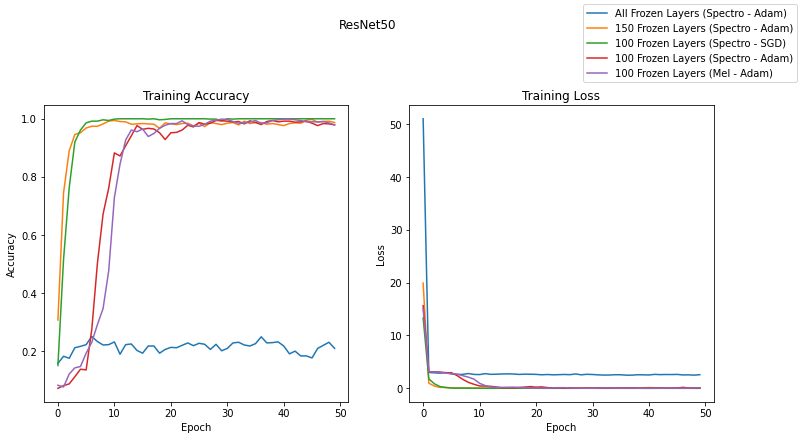

In [ ]:
fig = plt.figure(figsize=(12,12))
plt.subplot(221)
plt.plot(hist2.history['accuracy'])
plt.plot(hist4.history['accuracy'])
plt.plot(hist1.history['accuracy'])
plt.plot(hist.history['accuracy'])
plt.plot(hist_mel.history['accuracy'])
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')


plt.subplot(222)
plt.plot(hist2.history['loss'])
plt.plot(hist4.history['loss'])
plt.plot(hist1.history['loss'])
plt.plot(hist.history['loss'])
plt.plot(hist_mel.history['loss'])
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

fig.suptitle('ResNet50')
fig.legend(['All Frozen Layers (Spectro - Adam)', '150 Frozen Layers (Spectro - Adam)', '100 Frozen Layers (Spectro - SGD)',
            '100 Frozen Layers (Spectro - Adam)', '100 Frozen Layers (Mel - Adam)'], loc = 'best')
plt.show()